## Prelude

In [2]:
%pip install datasets
%pip install matplotlib
%pip install piecewise-regression

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import os
import json
import piecewise_regression

from datasets import load_dataset

from math import exp

In [4]:
SEED = 42

In [5]:
from calibration_dataset import CalibrationDataset
from calibration_run import CalibrationRun

### GSM8K-specific

In [6]:
gsm8k_df = pd.DataFrame(load_dataset("gsm8k", "main")["test"])

### MATH-specific

In [7]:
%pip install git+https://github.com/hendrycks/math.git

  Cloning https://github.com/hendrycks/math.git to /private/var/folders/cd/tvz6m38s0sj69mjqw_mcf4sc0000gn/T/pip-req-build-3972tc6o
  Running command git clone --filter=blob:none --quiet https://github.com/hendrycks/math.git /private/var/folders/cd/tvz6m38s0sj69mjqw_mcf4sc0000gn/T/pip-req-build-3972tc6o
  Resolved https://github.com/hendrycks/math.git to commit 357963a7f5501a6c1708cf3f3fb0cdf525642761
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [8]:
from math_equivalence import is_equiv as boxed_answer_is_equiv

In [9]:
def cost_acc_curve_points(confidence_estimator, run1, run2, cost1, cost2):
    run1_confs = run1.get_confs(confidence_estimator)
    run2_acc = 0.88

    curve_points = []
    for conf_threshold in np.linspace(0, 1, 100):
        attempts_meeting_conf_threshold = run1_confs[run1_confs[confidence_estimator] >= conf_threshold]
        pct_meeting_conf_threshold = len(attempts_meeting_conf_threshold) / len(run1_confs)
        cost = cost1 + cost2 * (1 - pct_meeting_conf_threshold)
        acc = attempts_meeting_conf_threshold['correct'].mean() * pct_meeting_conf_threshold + (run2_acc - pct_meeting_conf_threshold)
        curve_points.append((conf_threshold, cost, acc))

    return pd.DataFrame(data=curve_points, columns=['conf_threshold', 'cost', 'acc'])

## GSM8K

In [10]:
def gsm8k_str_to_num_parser(s : str) -> float:
    if isinstance(s, float) or isinstance(s, int):
        return s
    try:
        ending = s.split("####")[-1]
        strip_non_numbers = "".join((c for c in ending if (c in "1234567890.-")))
        return float(strip_non_numbers)
    except Exception as e:
        return float("nan")
    
def gsm8k_is_equiv(s1, s2):
    return gsm8k_str_to_num_parser(s1) == gsm8k_str_to_num_parser(s2)
    
def gsm8k_get_prompt_content(question, examples_text):
    return (
        "Please answer the following question.\n\n"
        + f"Question: {question}\n\n"
        + "Please give your reasoning, then output your final answer as a single number immediately preceded by #### with nothing after.\n\n"
        + f"Examples:\n\n{examples_text}"
    )

def gsm8k_get_tokens_prob(logprobs):
    token_count = 0
    for token in logprobs['tokens'][::-1][1:]:
        if token == "####":
            break
        token_count += 1
    tokens_prob = exp(sum(logprobs['token_logprobs'][-(token_count):-1]))
    return tokens_prob

In [15]:
gsm8k_all = CalibrationDataset(
    dataset_name="gsm8k_all",
    df = gsm8k_df,
    is_equiv = gsm8k_is_equiv,
    get_value_from_response=gsm8k_str_to_num_parser,
    get_prompt_content=gsm8k_get_prompt_content,
    get_value_tokens_prob=gsm8k_get_tokens_prob,
    seed=SEED,
)

### All 8B

In [16]:
gsm8k_all_llama3_8b = CalibrationRun(
    dataset=gsm8k_all,
    model_name="meta-llama/Meta-Llama-3-8B-Instruct",
    num_questions=1319,
    num_attempts_per_question=20,
    num_shots=5,
    max_response_tokens=1000,
    requests_file_path="requests/gsm8k_all_llama3_8b.jsonl",
    results_file_pattern="results/gsm8k_all_llama3_8b.jsonl*",
)
# gsm8k_all_llama3_8b.write_requests_file()
gsm8k_all_llama3_8b.read_results_file()

Lines dropped: 0


100%|██████████| 26380/26380 [00:00<00:00, 161502.58it/s]


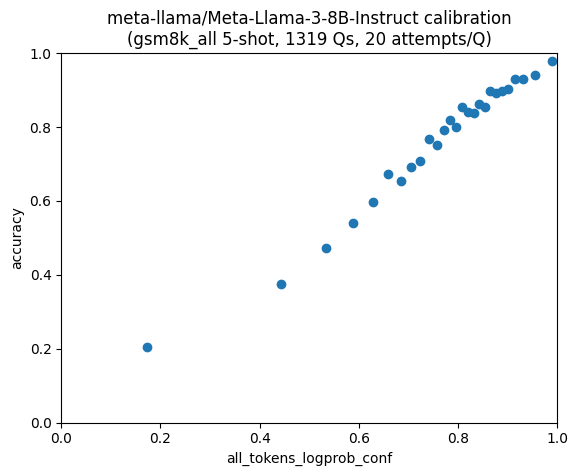

In [17]:
gsm8k_all_llama3_8b.plot_estimated_confidence_vs_accuracy(confidence_estimator="all_tokens_logprob_conf", qa_pairs_per_bin=1000)

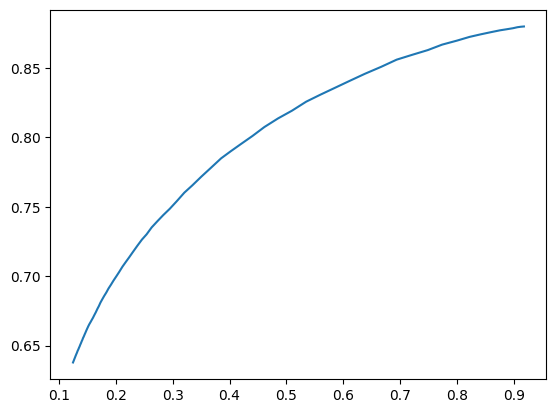

In [18]:
test = cost_acc_curve_points("all_tokens_logprob_conf", gsm8k_all_llama3_8b, None, 0.12, 0.8)
plt.plot(test['cost'], test['acc'])

### All 70B

In [20]:
gsm8k_all_llama3_70b = CalibrationRun(
    dataset=gsm8k_all,
    model_name="meta-llama/Meta-Llama-3-70B-Instruct",
    num_questions=1319,
    num_attempts_per_question=20,
    num_shots=5,
    max_response_tokens=1000,
    requests_file_path="requests/gsm8k_all_llama3_70b.jsonl",
    results_file_pattern="results/gsm8k_all_llama3_70b.jsonl*",
)
# gsm8k_all_llama3_70b.write_requests_file()
gsm8k_all_llama3_70b.read_results_file()

Lines dropped: 0


KeyError: 'response'

### Cost-Accuracy Tradeoff

### Other GSM8K

In [235]:
gsm8k_50_llama3_8b = CalibrationRun(
    dataset=gsm8k_all,
    model_name="meta-llama/Meta-Llama-3-8B-Instruct",
    num_questions=50,
    num_attempts_per_question=20,
    num_shots=5,
    max_response_tokens=1000,
    requests_file_path="requests/gsm8k_50_llama3_8b.jsonl",
    results_file_pattern="results/gsm8k_50_llama3_8b.jsonl*",
)
gsm8k_50_llama3_8b.write_requests_file()
gsm8k_50_llama3_8b.read_results_file()
gsm8k_50_llama3_8b.top1_acc()

Lines dropped: 0


100%|██████████| 1000/1000 [00:00<00:00, 151075.32it/s]


0.88

In [216]:
test = gsm8k_50_llama3_8b.get_binned("all_tokens_logprob", qa_pairs_per_bin=50)
display(test)
pw_fit = piecewise_regression.Fit(np.array(test.all_tokens_logprob), np.array(test.correct), n_breakpoints=3)
# gsm8k_50_llama3_8b.get_confs("tokens_prob")
# gsm8k_50_llama3_8b.plot_estimated_confidence_vs_accuracy("tokens_prob")

,all_tokens_logprob,correct
bin,,
0,-62.635323,0.34
1,-46.345504,0.48
2,-39.694988,0.60
3,-35.652041,0.48
4,-32.447806,0.62
5,-29.782472,0.68
6,-27.189474,0.68
7,-25.286062,0.72
8,-23.675939,0.76


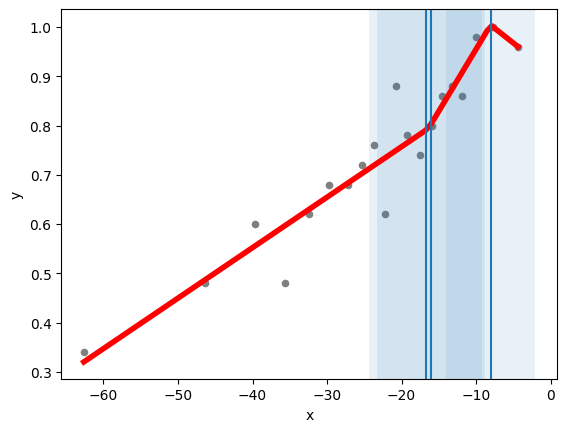

In [218]:
# pw_fit.summary()
pw_fit.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=4)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()

In [223]:
gsm8k_all_llama3_70b = CalibrationRun(
    dataset=gsm8k_all,
    model_name="meta-llama/Meta-Llama-3-70B-Instruct",
    num_questions=1319,
    num_attempts_per_question=20,
    num_shots=5,
    max_response_tokens=1000,
    requests_file_path="requests/gsm8k_all_llama3_70b.jsonl",
    results_file_path="results/gsm8k_all_llama3_70b.jsonl",
)
gsm8k_all_llama3_70b.write_requests_file()
# gsm8k_all_llama3_70b.read_results_file()

TypeError: __init__() got an unexpected keyword argument 'results_file_path'

## MATH (1000 Qs)

In [11]:
def extract_boxed_expression(input_string):
    start_idx = input_string.find(r"\boxed{")
    if start_idx == -1:
        return None

    start_idx += len(r"\boxed{")
    brace_count = 1
    result = []

    for idx in range(start_idx, len(input_string)):
        char = input_string[idx]
        result.append(char)
        
        if char == '{':
            brace_count += 1
        elif char == '}':
            brace_count -= 1
            if brace_count == 0:
                # We've found the closing brace for \boxed{
                return ''.join(result[:-1])  # Exclude the last closing brace
    
    return None

def get_math_df(data_path, split):
    jsons = []
    for root, dirs, files in os.walk(os.path.join(data_path, split)):
        for name in files:
            if name.endswith((".json")):
                full_path = os.path.join(root, name)
                with open(full_path, "r") as f:
                    jsons.append(json.load(f))
    
    df = pd.DataFrame.from_dict(jsons).rename(columns={'problem': 'question', 'solution': 'answer'})
    df['q_id'] = df.index

    return df

def math_is_equiv(s1, s2):
    return boxed_answer_is_equiv(extract_boxed_expression(s1), extract_boxed_expression(s2))

def math_get_prompt_content(question, examples_text):
    return (
        "Please answer the following question.\n\n"
        + f"Question: {question}\n\n"
        + "Please give your reasoning, then output your final answer inside \\boxed{}.\n\n"
        + f"Examples:\n\n{examples_text}"
    )

In [12]:
math_all = CalibrationDataset(
    dataset_name="math_all",
    df = get_math_df("MATH/", "test"),
    is_equiv=math_is_equiv,
    get_value_from_response=extract_boxed_expression,
    get_prompt_content=math_get_prompt_content,
    get_value_tokens_prob=None,
    seed=SEED,
)

### 1000Q 8B

In [17]:
math_1000q_llama3_8b = CalibrationRun(
    dataset=math_all,
    model_name="meta-llama/Meta-Llama-3-8B-Instruct",
    num_questions=1000,
    num_attempts_per_question=20,
    num_shots=5,
    max_response_tokens=5000,
    requests_file_path="requests/math_1000q_llama3_8b.jsonl",
    results_file_pattern="results/math_1000q_llama3_8b.jsonl*",
)
math_1000q_llama3_8b.write_requests_file()

### 1000Q 70B

In [13]:
math_1000q_llama3_70b = CalibrationRun(
    dataset=math_all,
    model_name="meta-llama/Meta-Llama-3-70B-Instruct",
    num_questions=1000,
    num_attempts_per_question=20,
    num_shots=5,
    max_response_tokens=5000,
    requests_file_path="requests/math_1000q_llama3_70b.jsonl",
    results_file_pattern="results/math_1000q_llama3_70b.jsonl*",
)
math_1000q_llama3_70b.write_requests_file()